# Kanji OCR Project - main notebook

## Load dependencies

In [2]:
import tensorflow as tf
from tensorflow import keras
import imageio.v3 as iio
import numpy as np
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import keras_tuner as kt
# import cv2
import os

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=$CONDA_PREFIX/lib'

# KANJI START AT INDEX 71
base_path = '9G'
joyo_kanji = ''
fm.findSystemFonts()

with open('joyoKanji') as f:
    joyo_kanji = f.read()
with open('rtk3') as f:
    joyo_kanji += f.read()
matplotlib.rcParams['font.family'] = 'Yuji Syuku'
matplotlib.rcParams['font.size'] = 18

## Load dataset

In [3]:
data = tf.keras.utils.image_dataset_from_directory(base_path, color_mode="grayscale", label_mode="categorical", image_size=(127, 128), batch_size=128)

Found 570200 files belonging to 2851 classes.


2023-07-13 21:08:26.578009: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
class_names = data.class_names
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

2023-07-13 21:10:35.239989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [570200]
	 [[{{node Placeholder/_0}}]]
2023-07-13 21:10:35.240295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [570200]
	 [[{{node Placeholder/_4}}]]


In [5]:
print(batch[0].shape)
print(batch[1].shape)

(128, 127, 128, 1)
(128, 2851)


## Show data

Unscaled Data:
min: 15.0 max: 255.0


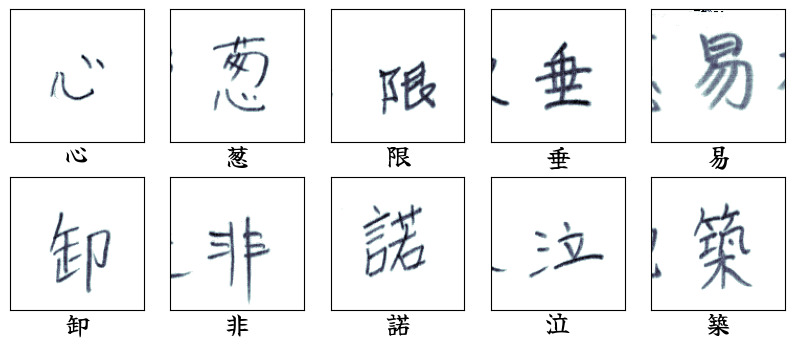

In [6]:
characters = batch[0]
print('Unscaled Data:')
print('min:', characters.min(), 'max:', characters.max())
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(characters[i], cmap=plt.cm.bone)
    plt.xlabel(class_names[np.where(batch[1][i] == 1)[0][0]])
plt.show()

## Preprocess data

In [7]:
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()

2023-07-13 21:10:55.651785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [570200]
	 [[{{node Placeholder/_4}}]]
2023-07-13 21:10:55.652045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [570200]
	 [[{{node Placeholder/_4}}]]


In [8]:
batch = scaled_iterator.next()

Scaled Data:
min: 0.05882353 max: 1.0


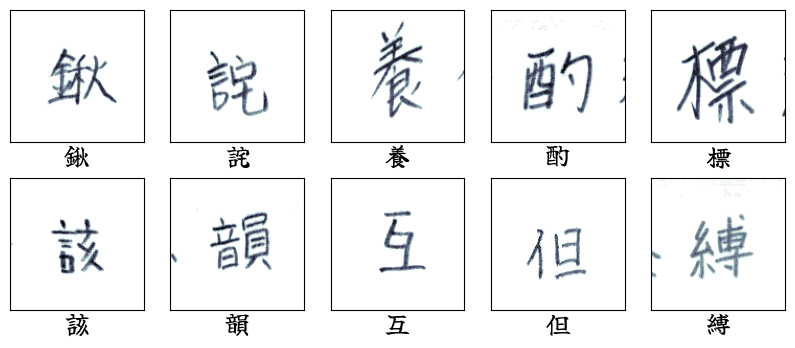

In [9]:
characters = batch[0]
print('Scaled Data:')
print('min:', characters.min(), 'max:', characters.max())
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(characters[i], cmap=plt.cm.bone)
    plt.xlabel(class_names[np.where(batch[1][i] == 1)[0][0]])
plt.show()

In [10]:
train_share = .7
val_share = .2
test_share = .1

In [11]:
train_size = int(len(data) * train_share)
val_size = int(len(data) * val_share)
test_size = int(len(data) * test_share)

In [12]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

## Define the model

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

In [ ]:
# def model_builder(hp):
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(127,128)))

#     hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
#     hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
#     hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.add(keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
#     model.add(keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
#     model.add(keras.layers.Dense(len(class_names), activation='softmax'))
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy())

In [ ]:
# tuner = kt.Hyperband(model_builder, objective='accuracy', max_epochs=10, factor=3, directory='dir', project_name='kanji-ocr-tuned')

In [ ]:
# tuner.search(data, epochs=50, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# tuned_model = tuner.hypermodel.build(best_hps)
# then fit

In [14]:
model = keras.Sequential()

In [15]:
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(127,128,1)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax'))


In [16]:
model.compile('adam', tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0

## Train the model

In [17]:
logdir='logs'

In [18]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[tensorboard_callback, reduce_lr], verbose=1)

Epoch 1/100


2023-07-13 21:12:47.989083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [570200]
	 [[{{node Placeholder/_0}}]]
2023-07-13 21:12:47.989347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [570200]
	 [[{{node Placeholder/_0}}]]


 441/3118 [===>..........................] - ETA: 11:53 - loss: 7.9564 - accuracy: 2.8345e-04

KeyboardInterrupt: 

## Run tests and export

In [83]:
model.save(os.path.join('models', 'checkpoint-kanji-ocr-model.h5'))
loaded_model = keras.models.load_model(os.path.join('models', 'checkpoint-kanji-ocr-model.h5'))

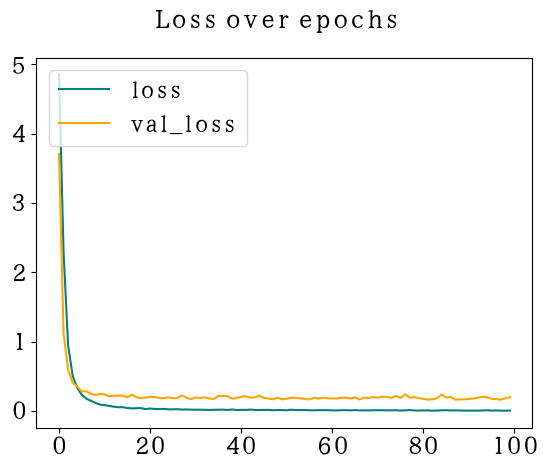

In [84]:
# model.save(os.path.join('models', 'checkpoint-kanji-ocr-model.h5'))
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss over epochs', fontsize=20)
plt.legend(loc="upper left")
plt.show()

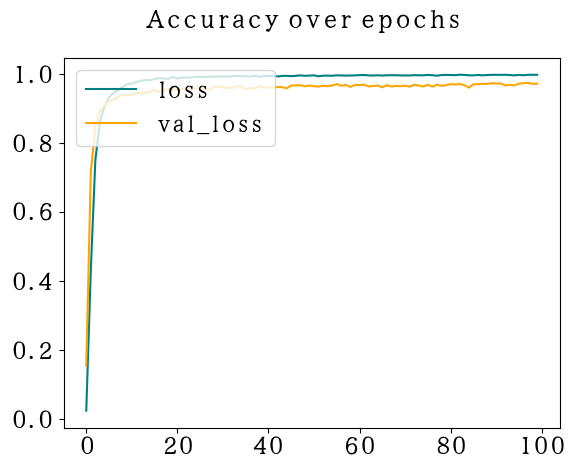

In [85]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy over epochs', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [86]:
pre = keras.metrics.Precision()
re = keras.metrics.Recall()
acc = keras.metrics.CategoricalAccuracy()

In [87]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-07-13 20:07:27.971520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29200]
	 [[{{node Placeholder/_4}}]]
2023-07-13 20:07:27.971797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29200]
	 [[{{node Placeholder/_4}}]]


4/4 [==============================] - 0s 10ms/step


In [88]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9690170884132385, Recall: 0.9662641882896423, Accuracy: 0.9662641882896423


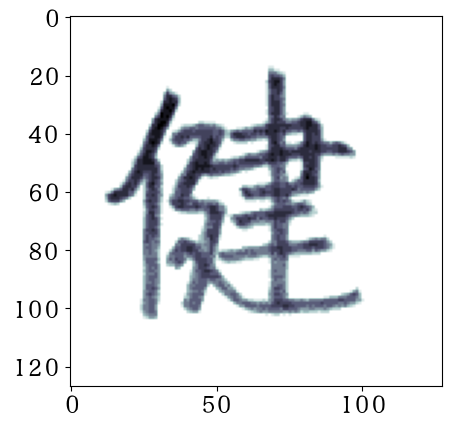

In [89]:
img = iio.imread('8G/健/004612.png')
plt.imshow(img, cmap=plt.cm.bone)
plt.show()

In [90]:
resize = img
# resize = tf.image.resize(img, (127, 128))
# plt.imshow(resize, cmap=plt.cm.bone)
# plt.show()

Found 141841 files belonging to 881 classes.


2023-07-13 20:07:39.685147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [141841]
	 [[{{node Placeholder/_4}}]]
2023-07-13 20:07:39.685369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [141841]
	 [[{{node Placeholder/_0}}]]


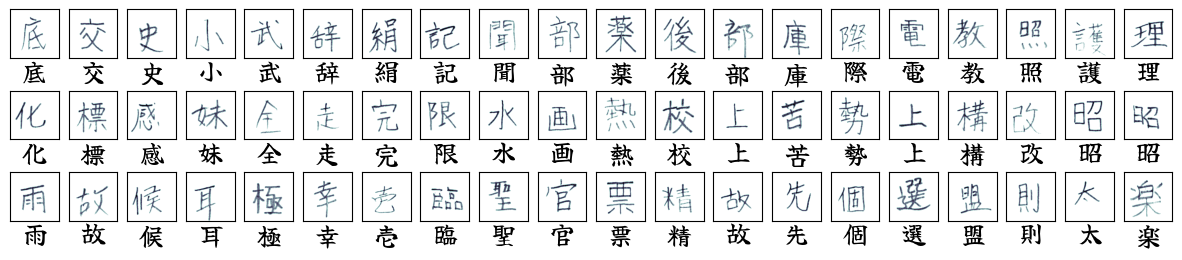

In [91]:
new_data = keras.utils.image_dataset_from_directory('8G', label_mode="categorical", color_mode="grayscale", image_size=(127,128), batch_size=70)
it = new_data.map(lambda x,y: (x/255, y)).as_numpy_iterator()
batch = it.next()
plt.figure(figsize=(15, 3))
for i in range(60):
    try:
        plt.subplot(3,20,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.bone)
        plt.xlabel(new_data.class_names[np.where(batch[1][i] == 1)[0][0]])
    except:
        print('', end='')
plt.show()

(70, 127, 128, 1)
3/3 [==============================] - 0s 9ms/step


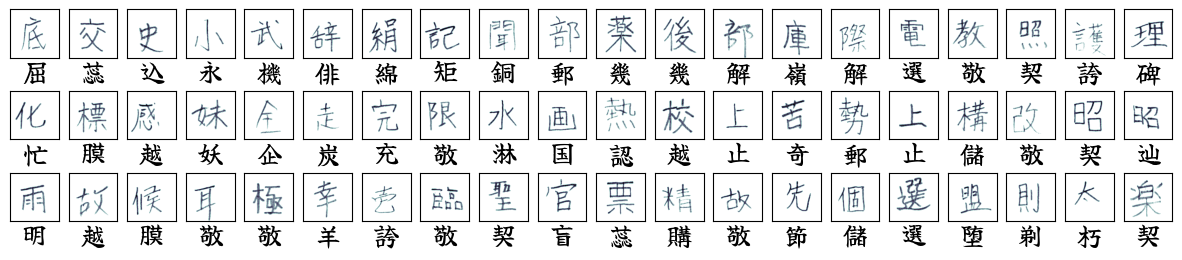

In [92]:
xhat = batch[0]
print(xhat.shape)
yhat = loaded_model.predict(xhat)
# yhat = model.predict(np.expand_dims(resize/255, 0))
# print(class_names[np.where(yhat == np.max(yhat, axis=1))[0][0]])
plt.figure(figsize=(15, 3))
for i in range(60):
    try:
        plt.subplot(3,20,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(xhat[i], cmap=plt.cm.bone)
        plt.xlabel(class_names[np.where(yhat[i] == np.max(yhat[i]))[0][0]])
    except:
        print('', end='')
plt.show()

In [93]:
model.save(os.path.join('models', 'kanji-ocr-model.h5'))

In [94]:
loaded_model = keras.models.load_model(os.path.join('models', 'kanji-ocr-model.h5'))
print(loaded_model)

In [95]:
yhat_new = loaded_model.predict(np.expand_dims(resize/255, 0))
print(class_names[np.where(yhat_new == 1)[0][0]])

1/1 [==============================] - 0s 45ms/step


IndexError: index 0 is out of bounds for axis 0 with size 0